In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.temporal_clue import TemporalClueCpModel, TemporalClueScenario

scenario = TemporalClueScenario(
    min_players=1,
    max_players=3,
    # max_suspects=4,
    # max_weapons=3,
    # max_rooms=4,
    # max_times=1,
    # max_motives=1,
    # unique_motives=False,
)
scenario

TemporalClue(
    suspects=["Madame Rose", "Sgt. Gray", "Miss Peach"],
    weapons=["Revolver", "Wrench", "Knife"],
    rooms=["Trophy Room", "Billiard Room", "Kitchen"],
    times=["11:45 PM", "12:00 AM"],
    motives=["Betrayal", "Anger"],
    murderer="Madame Rose",
    murder_weapon="Wrench",
    murder_room="Kitchen",
    murder_time="11:45 PM",
)

In [3]:
import json
from multiprocessing import Pool
import os
import random
import string
import time

def generate_worker_id():
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))

def worker(worker_id):
    duration = 60 * 60 * 10  # 10 hours
    start = time.time()
    worker_file = f"./data/temporal-clue-puzzles-{worker_id}.json"
    
    # Initialize worker file if it doesn't exist
    if not os.path.exists(worker_file):
        with open(worker_file, "w") as f:
            json.dump([], f)
            
    while time.time() - start < duration:
        puzzle = TemporalClueScenario().create_puzzle()
        try:
            with open(worker_file, "r") as f:
                json_puzzles = json.loads(f.read())
            json_puzzles.append(puzzle.json_data())
            with open(worker_file, "w") as f:
                json.dump(json_puzzles, f, indent=2)
        except Exception as e:
            print(f"Error writing puzzle for worker {worker_id}: {e}")

num_processes = os.cpu_count() // 2  # type: ignore

# Create data directory if it doesn't exist
os.makedirs("./data", exist_ok=True)

worker_ids = [generate_worker_id() for _ in range(num_processes)]
with Pool(num_processes) as p:
    p.map(worker, worker_ids)

In [15]:
json_puzzles = json.loads(open("./data/temporal-clue-puzzles.json").read())
len(json_puzzles)

455

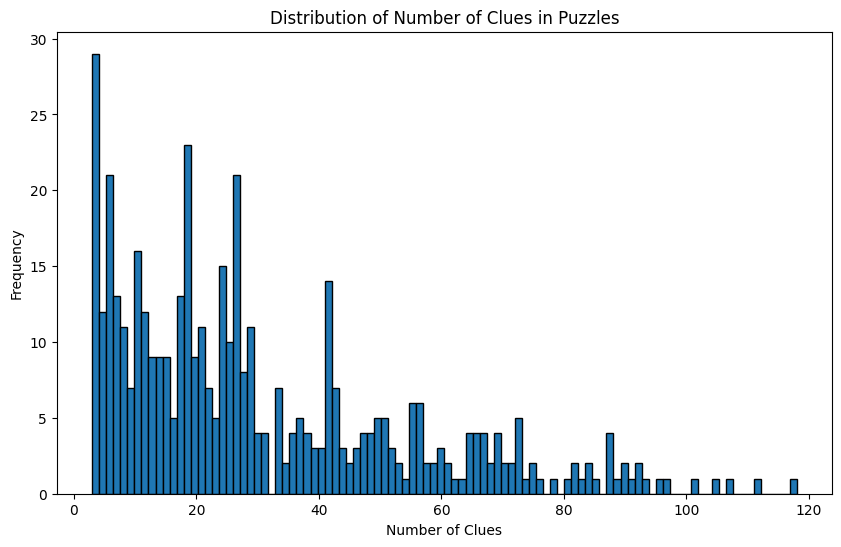

In [16]:
import matplotlib.pyplot as plt

num_clues = [p["num_clues"] for p in json_puzzles]
plt.figure(figsize=(10, 6))
plt.hist(num_clues, bins=100, edgecolor='black')
plt.xlabel('Number of Clues')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Clues in Puzzles')
plt.show()

In [45]:
puzzle = max(puzzles, key=lambda p: len(p.clues))
print(puzzle.prompt())

On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Professor Plum
• Mrs. Peacock
• Mrs. White
• Monsieur Brunette
• Miss Peach
• Madame Rose
• Colonel Mustard
• Mr. Green
• Sgt. Gray
• Miss Scarlet

And the following weapons were found on the premises:

• Poison
• Knife
• Wrench
• Candlestick
• Lead Pipe
• Horseshoe
• Rope

The murder could only have occured in one of the following rooms:

01. Lounge
02. Courtyard
03. Drawing Room
04. Dining Room
05. Trophy Room
06. Studio
07. Fountain
08. Hall
09. Study
10. Cloak Room
11. Library
12. Billiard Room

The rooms are laid out as follows:

  NN NN NN  
W 01|02|03 E
W 04|05|06 E
W 07|08|09 E
W 10|11|12 E
  SS SS SS  

The exact time of the murder i

In [46]:
puzzle.scenario.create_printable_boards("temporal-clue.pdf")

In [41]:
print(puzzles[14].scenario.formatted_board())

  N N  
W 1|2 E
W 3|4 E
W 5|6 E
  S S  


In [25]:
print(puzzle.scenario.formatted_board())

  NN NN NN  
W 01|02|03 E
W 04|05|06 E
W 07|08|09 E
W 10|11|12 E
  SS SS SS  


Index(['clues', 'indirect', 'spatial_relation', 'iff', 'character_move',
       'motive', 'same_time_or_place', 'same_time', 'direct',
       'piece_time_room', 'same_room', 'xor', 'murder_weapon', 'murderer',
       'weapon_move', 'solution', 'murder_time'],
      dtype='object')

<Axes: xlabel='clues', ylabel='solution'>

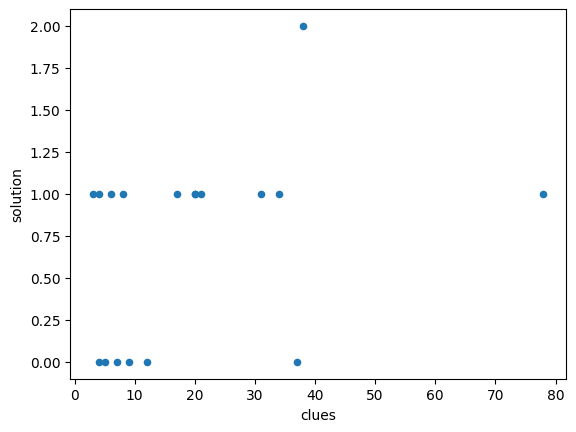

In [20]:
import pandas as pd

df = pd.DataFrame(
    [
        {
            "clues": len(puzzle.clues),
            **puzzle.tag_counts,
        }
        for puzzle in puzzles
    ]
)
df.fillna(0, inplace=True)
df = df.astype(int)
df.sort_values("clues", inplace=True)

display(df.columns)
df.plot.scatter(x="clues", y="solution")

In [19]:
puzzle = scenario.create_puzzle()
print(puzzle.prompt())
display(puzzle.all_questions)
display(puzzle.tag_counts)

On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Miss Scarlet
• Monsieur Brunette

And the following weapons were found on the premises:

• Knife
• Wrench

The murder could only have occured in one of the following rooms:

1. Fountain
2. Carriage House

The rooms are laid out as follows:

  N N  
W 1|2 E
  S S  

The exact time of the murder is a bit uncertain, but it has been narrowed down to one of the following times:

• 11:45 PM
• 12:00 AM

At every time the suspects and Mr. Boddy either stayed in their current room or moved to an orthogonally adjacent room (north, south, east, or west). Weapons could be moved by suspects between rooms as well.

For the murder to occur, the murderer and

{'Who murdered Mr. Boddy?': 'Miss Scarlet',
 'What weapon did the murderer use?': 'Knife',
 'Where was the murder committed?': 'Fountain',
 'When did the murder occur?': '12:00 AM',
 'Where was Miss Scarlet at 12:00 AM?': 'Fountain',
 'Where was the Wrench at 12:00 AM?': 'Carriage House'}

Counter({'indirect': 7,
         'same_time_or_place': 3,
         'iff': 2,
         'same_time': 2,
         'spatial_relation': 1,
         'xor': 1,
         'murder_weapon': 1,
         'murderer': 1,
         'same_room': 1})

In [86]:
print(puzzle.prompt())

On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Miss Scarlet
• Sgt. Gray
• Professor Plum
• Colonel Mustard
• Mrs. White
• Mrs. Peacock
• Miss Peach

And the following weapons were found on the premises:

• Candlestick
• Horseshoe
• Knife
• Lead Pipe
• Poison
• Rope

The murder could only have occured in one of the following rooms:

1. Studio
2. Ballroom
3. Study
4. Library
5. Dining Room
6. Gazebo
7. Courtyard
8. Billiard Room

The rooms are laid out as follows:

  N N N  
W 1|2|3 E
W 4|5|6 E
W 7|8|- E
  S S S  

The exact time of the murder is a bit uncertain, but it has been narrowed down to one of the following times:

• 11:00 PM
• 12:00 AM
• 01:00 AM
• 02:00 AM

At every time the susp

In [87]:
display(puzzle.all_questions)

{'Who murdered Mr. Boddy?': 'Miss Peach',
 'What weapon did the murderer use?': 'Poison',
 'Where was the murder committed?': 'Ballroom',
 'When did the murder occur?': '02:00 AM',
 'Why did the murderer do it?': 'Greed',
 'Where was the Candlestick at 01:00 AM?': 'Studio',
 'Where was the suspect motivated by Jealousy at 01:00 AM?': 'Dining Room',
 'Where was the suspect motivated by Betrayal at 01:00 AM?': 'Gazebo'}

In [44]:
scenario.create_printable_boards("temporal-clue.pdf")

In [73]:
print(scenario.formatted_board())

  N N N  
W 1|2|3 E
W 4|5|6 E
W 7|8|9 E
  S S S  


In [74]:
scenario.piece_time_rooms

{'Professor Plum': {'11:00 PM': 'Hall',
  '11:30 PM': 'Gazebo',
  '12:00 AM': 'Gazebo',
  '12:30 AM': 'Kitchen',
  '01:00 AM': 'Kitchen',
  '01:30 AM': 'Studio'},
 'Miss Scarlet': {'11:00 PM': 'Kitchen',
  '11:30 PM': 'Conservatory',
  '12:00 AM': 'Trophy Room',
  '12:30 AM': 'Trophy Room',
  '01:00 AM': 'Conservatory',
  '01:30 AM': 'Kitchen'},
 'Monsieur Brunette': {'11:00 PM': 'Trophy Room',
  '11:30 PM': 'Trophy Room',
  '12:00 AM': 'Conservatory',
  '12:30 AM': 'Hall',
  '01:00 AM': 'Hall',
  '01:30 AM': 'Hall'},
 'Colonel Mustard': {'11:00 PM': 'Study',
  '11:30 PM': 'Study',
  '12:00 AM': 'Study',
  '12:30 AM': 'Study',
  '01:00 AM': 'Hall',
  '01:30 AM': 'Hall'},
 'Madame Rose': {'11:00 PM': 'Billiard Room',
  '11:30 PM': 'Conservatory',
  '12:00 AM': 'Hall',
  '12:30 AM': 'Hall',
  '01:00 AM': 'Study',
  '01:30 AM': 'Study'},
 'Mrs. Peacock': {'11:00 PM': 'Fountain',
  '11:30 PM': 'Billiard Room',
  '12:00 AM': 'Billiard Room',
  '12:30 AM': 'Fountain',
  '01:00 AM': 'Trophy R

In [77]:
puzzle = scenario.create_puzzle()
print(puzzle.prompt())
display(puzzle.all_questions)

On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Mr. Green
• Colonel Mustard
• Sgt. Gray
• Monsieur Brunette
• Miss Scarlet
• Madame Rose
• Professor Plum

And the following weapons were found on the premises:

• Revolver
• Rope
• Poison
• Candlestick
• Horseshoe
• Wrench

The murder could only have occured in one of the following rooms:

1. Kitchen
2. Drawing Room
3. Study
4. Conservatory
5. Billiard Room
6. Fountain
7. Ballroom
8. Lounge
9. Trophy Room

The rooms are laid out as follows:

  N N N  
W 1|2|3 E
W 4|5|6 E
W 7|8|9 E
  S S S  

The exact time of the murder is a bit uncertain, but it has been narrowed down to one of the following times:

• 11:00 PM
• 11:30 PM
• 12:00 AM
• 12:30 

{'Who murdered Mr. Boddy?': 'Madame Rose',
 'Where was the murder committed?': 'Kitchen',
 'When did the murder occur?': '01:30 AM',
 'Why did the murderer do it?': 'Jealousy',
 'Where was the Revolver at 12:00 AM?': 'Ballroom',
 'Where was the Poison at 11:30 PM?': 'Trophy Room'}

In [1347]:
display(puzzle.bonus_questions)

{'Where was Professor Plum at 12:00 AM?': 'Billiard Room',
 'Where was the Rope at 12:00 AM?': 'Hall'}

In [1345]:
import re

prompt = puzzle.prompt()
prompt = re.sub(
    r"\nThe exact time of the murder.*by suspects between rooms as well.\n",
    "",
    prompt,
    flags=re.DOTALL,
)
prompt = re.sub(
    r" at some point in the night\. Any clue about Mr\. Boddy's whereabouts should be read as \"Mr\. Boddy \(dead or alive\) \.\.\.\"",
    ".",
    prompt,
    flags=re.DOTALL,
)
prompt = re.sub(
    " at least once",
    "",
    prompt,
    flags=re.DOTALL,
)
prompt = re.sub(
    " at 12:00 AM",
    "",
    prompt,
    flags=re.DOTALL,
)
print(prompt)

On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Miss Scarlet
• Sgt. Gray
• Mrs. White
• Professor Plum
• Mr. Green

And the following weapons were found on the premises:

• Knife
• Rope
• Revolver
• Candlestick

The murder could only have occured in one of the following rooms:

1. Kitchen
2. Dining Room
3. Fountain
4. Billiard Room
5. Hall

The rooms are laid out as follows:

  N N N  
W 1|2|3 E
W 4|5|- E
  S S S  

For the murder to occur, the murderer and Mr. Boddy must have been alone in a room with at least one weapon.

The available clues are as follows:

- The murderer was in the Dining Room or the Candlestick was in the Kitchen
- Miss Scarlet was in the same room as Professor Plum
-

In [19]:
scenario.weapon_moves

[]

In [10]:
len(puzzle.clues), len(list(scenario.direct_clues()))

(18, 28)

In [8]:
[1, 1] > [1]

True

In [4]:
scenario.piece_time_rooms

{'Professor Plum': {'10:00 PM': 'Kitchen',
  '11:00 PM': 'Kitchen',
  '12:00 AM': 'Kitchen'},
 'Madame Rose': {'10:00 PM': 'Cloak Room',
  '11:00 PM': 'Cloak Room',
  '12:00 AM': 'Kitchen'},
 'Miss Scarlet': {'10:00 PM': 'Trophy Room',
  '11:00 PM': 'Cloak Room',
  '12:00 AM': 'Kitchen'},
 'Colonel Mustard': {'10:00 PM': 'Kitchen',
  '11:00 PM': 'Cloak Room',
  '12:00 AM': 'Kitchen'},
 'Horseshoe': {'10:00 PM': 'Cloak Room',
  '11:00 PM': 'Cloak Room',
  '12:00 AM': 'Kitchen'},
 'Lead Pipe': {'10:00 PM': 'Cloak Room',
  '11:00 PM': 'Cloak Room',
  '12:00 AM': 'Kitchen'},
 'Knife': {'10:00 PM': 'Trophy Room',
  '11:00 PM': 'Trophy Room',
  '12:00 AM': 'Trophy Room'},
 'Mr. Boddy': {'10:00 PM': 'Trophy Room',
  '11:00 PM': 'Trophy Room',
  '12:00 AM': 'Trophy Room'}}

In [9]:
model = TemporalClueCpModel(scenario)
model

AttributeError: 'TemporalClueCpModel' object has no attribute '_TemporalClueCpModel__model'

In [8]:
model.__model.variables

AttributeError: 'TemporalClueCpModel' object has no attribute '__model'

In [31]:
scenario.sufficient_clues(model)

False

In [3]:
from dataclasses import dataclass
from lib.clue import Clue
from lib.utils import black_print
import math
import numpy as np
from ortools.sat.python import cp_model
import random
from typing import Iterable, NewType

Suspect = NewType("Suspect", str)
Weapon = NewType("Weapon", str)
Room = NewType("Room", str)
Motive = NewType("Motive", str)
Time = NewType("Time", str)

num_players = random.randint(3, 6)
num_weapons = max(
    3,
    min(
        num_players + random.randint(-1, 5),
        len(Clue.weapons),
    ),
)
num_suspects = min(num_weapons + random.randint(0, num_weapons - 1), len(Clue.suspects))
num_rooms = min(num_suspects + random.randint(0, num_suspects - 2), len(Clue.rooms))
suspects = [Suspect(s) for s in random.sample(Clue.suspects, k=num_suspects)]
weapons = [Weapon(w) for w in random.sample(Clue.weapons, k=num_weapons)]
rooms = [Room(r) for r in random.sample(Clue.rooms, k=num_rooms)]
if random.random() < 0.1:
    motives = [
        Motive(m)
        for m in random.sample(
            Clue.motives,
            k=max(3, min(num_weapons + random.randint(-1, 3), len(Clue.motives))),
        )
    ]
frequency = random.choice([0.25, 0.5, 1.0])
start = 24.0 - frequency
end = 0.0
for _ in range(random.randint(1, num_weapons)):
    if random.randint(0, 1):
        end += frequency
    else:
        start -= frequency


def format_time(time: float) -> str:
    return f"{int(time):02d}:{int(60 * (time - int(time))):02d}"


times = [
    Time(t)
    for t in Clue.get_times(
        format_time(start), format_time(end), f"{int(frequency * 60)}min"
    )
]

suspect_indices = {suspect: index for index, suspect in enumerate(suspects)}
weapon_indices = {weapon: index for index, weapon in enumerate(weapons)}
room_indices = {room: index for index, room in enumerate(rooms)}
time_indices = {time: index for index, time in enumerate(times)}

board_columns = {
    3: 2,
    4: 2,
    5: random.choice([2, 3]),
    6: random.choice([2, 3]),
    7: 3,
    8: 3,
    9: 3,
    10: random.choice([3, 4]),
    11: random.choice([3, 4]),
    12: random.choice([3, 4]),
    13: 4,
    14: 4,
    15: 4,
    16: 4,
    17: 4,
}[len(rooms)]
board_rows = math.ceil(len(rooms) / board_columns)
room_coords = {
    room: (id % board_columns, board_rows - id // board_columns - 1)
    for id, room in enumerate(rooms)
}
coord_rooms = {v: k for k, v in room_coords.items()}
len(rooms), board_rows, board_columns, room_coords, coord_rooms

(3,
 2,
 2,
 {'Cloak Room': (0, 1), 'Gazebo': (1, 1), 'Billiard Room': (0, 0)},
 {(0, 1): 'Cloak Room', (1, 1): 'Gazebo', (0, 0): 'Billiard Room'})

In [4]:
def random_suspect_time_rooms() -> dict[Time, Room]:
    room = random.choice(rooms)
    time_rooms = {times[0]: room}
    for time in times[1:]:
        if random.random() < 0.5:
            coords = room_coords[room]
            room = random.choice(
                [
                    room
                    for room in (
                        coord_rooms.get((coords[0] + x, coords[1] + y))
                        for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                    )
                    if room is not None
                ]
            )
        time_rooms[time] = room
    return time_rooms

In [5]:
suspect_time_rooms = {suspect: random_suspect_time_rooms() for suspect in suspects}
black_print(suspect_time_rooms)

{
    "Mr. Green": {
        "11:30 PM": "Cloak Room",
        "11:45 PM": "Cloak Room",
        "12:00 AM": "Cloak Room",
        "12:15 AM": "Billiard Room",
    },
    "Mrs. White": {
        "11:30 PM": "Gazebo",
        "11:45 PM": "Gazebo",
        "12:00 AM": "Gazebo",
        "12:15 AM": "Gazebo",
    },
    "Sgt. Gray": {
        "11:30 PM": "Cloak Room",
        "11:45 PM": "Cloak Room",
        "12:00 AM": "Gazebo",
        "12:15 AM": "Cloak Room",
    },
}


In [6]:
time_room_suspects = {time: {room: set[Suspect]() for room in rooms} for time in times}
for suspect, time_rooms in suspect_time_rooms.items():
    for time, room in time_rooms.items():
        time_room_suspects[time][room].add(suspect)
black_print(time_room_suspects)

{
    "11:30 PM": {
        "Cloak Room": {"Mr. Green", "Sgt. Gray"},
        "Gazebo": {"Mrs. White"},
        "Billiard Room": set(),
    },
    "11:45 PM": {
        "Cloak Room": {"Mr. Green", "Sgt. Gray"},
        "Gazebo": {"Mrs. White"},
        "Billiard Room": set(),
    },
    "12:00 AM": {
        "Cloak Room": {"Mr. Green"},
        "Gazebo": {"Mrs. White", "Sgt. Gray"},
        "Billiard Room": set(),
    },
    "12:15 AM": {
        "Cloak Room": {"Sgt. Gray"},
        "Gazebo": {"Mrs. White"},
        "Billiard Room": {"Mr. Green"},
    },
}


In [7]:
@dataclass
class WeaponMove:
    weapon: Weapon
    suspect: Suspect
    time: Time
    from_room: Room
    to_room: Room


# Storing these is not strictly necessary, but it's easier than deriving them after the fact
weapon_moves: list[WeaponMove] = []


def random_weapon_time_rooms(weapon: Weapon) -> dict[Time, Room]:
    room = random.choice(rooms)
    time_rooms = {times[0]: room}
    suspect: Suspect | None = None
    for time in times[1:]:
        if (
            suspect
            and (suspect_room := suspect_time_rooms[suspect][time])
            and suspect_room != room
        ):
            # Weapon moved by the suspect to a different room
            weapon_moves.append(
                WeaponMove(
                    weapon=weapon,
                    suspect=suspect,
                    time=time,
                    from_room=room,
                    to_room=suspect_room,
                )
            )
            time_rooms[time] = room = suspect_room
        else:
            # There is no suspect or the suspect hasn't moved
            time_rooms[time] = room
        if suspects := time_room_suspects[time][room]:
            suspect = random.choice(list(suspects))
    return time_rooms


weapon_time_rooms = {weapon: random_weapon_time_rooms(weapon) for weapon in weapons}
black_print(weapon_moves)
black_print(weapon_time_rooms)

[
    WeaponMove(
        weapon="Candlestick",
        suspect="Mr. Green",
        time="12:15 AM",
        from_room="Cloak Room",
        to_room="Billiard Room",
    )
]
{
    "Candlestick": {
        "11:30 PM": "Cloak Room",
        "11:45 PM": "Cloak Room",
        "12:00 AM": "Cloak Room",
        "12:15 AM": "Billiard Room",
    },
    "Lead Pipe": {
        "11:30 PM": "Gazebo",
        "11:45 PM": "Gazebo",
        "12:00 AM": "Gazebo",
        "12:15 AM": "Gazebo",
    },
    "Wrench": {
        "11:30 PM": "Billiard Room",
        "11:45 PM": "Billiard Room",
        "12:00 AM": "Billiard Room",
        "12:15 AM": "Billiard Room",
    },
}


In [8]:
time_room_weapons = {time: {room: set[Weapon]() for room in rooms} for time in times}
for weapon, time_rooms in weapon_time_rooms.items():
    for time, room in time_rooms.items():
        time_room_weapons[time][room].add(weapon)
black_print(time_room_weapons)

{
    "11:30 PM": {
        "Cloak Room": {"Candlestick"},
        "Gazebo": {"Lead Pipe"},
        "Billiard Room": {"Wrench"},
    },
    "11:45 PM": {
        "Cloak Room": {"Candlestick"},
        "Gazebo": {"Lead Pipe"},
        "Billiard Room": {"Wrench"},
    },
    "12:00 AM": {
        "Cloak Room": {"Candlestick"},
        "Gazebo": {"Lead Pipe"},
        "Billiard Room": {"Wrench"},
    },
    "12:15 AM": {
        "Cloak Room": set(),
        "Gazebo": {"Lead Pipe"},
        "Billiard Room": {"Candlestick", "Wrench"},
    },
}


In [9]:
while True:
    murderer = random.choice(suspects)
    murder_time = random.choice(times)
    murder_room = suspect_time_rooms[murderer][murder_time]
    # Ensure the suspect is alone at the murder time in the murder room
    if len(time_room_suspects[murder_time][murder_room]) > 1:
        continue
    # Ensure there is at least one weapon in the murder room at the murder time
    if possible_weapons := time_room_weapons[murder_time][murder_room]:
        murder_weapon = random.choice(list(possible_weapons))
        break

black_print(
    {
        "murderer": murderer,
        "murder_weapon": murder_weapon,
        "murder_room": murder_room,
        "murder_time": murder_time,
    }
)

{
    "murderer": "Mrs. White",
    "murder_weapon": "Lead Pipe",
    "murder_room": "Gazebo",
    "murder_time": "11:45 PM",
}


In [10]:
black_print(
    {
        "num_suspects": len(suspects),
        "num_weapons": len(weapons),
        "num_rooms": len(rooms),
        "num_times": len(times),
        "num_weapon_moves": len(weapon_moves),
    }
)

{
    "num_suspects": 3,
    "num_weapons": 3,
    "num_rooms": 3,
    "num_times": 4,
    "num_weapon_moves": 1,
}


In [163]:
from functools import partial
from typing import Callable, TypeVar

model = cp_model.CpModel()

_all_vars: dict[frozenset[cp_model.IntVar], cp_model.IntVar] = {}
_sum_vars: dict[tuple[frozenset[cp_model.IntVar], int], cp_model.IntVar] = {}


def all_vars(
    *bool_vars: cp_model.IntVar,
) -> cp_model.IntVar:
    var_set = frozenset(bool_vars)
    if var_set in _all_vars:
        return _all_vars[var_set]
    var = model.new_bool_var(" and ".join(str(var) for var in var_set))
    model.add(sum(var_set) == len(var_set)).only_enforce_if(var)
    model.add(sum(var_set) < len(var_set)).only_enforce_if(~var)
    _all_vars[var_set] = var
    return var


def sum_vars(
    *bool_vars: cp_model.IntVar,
    value: int,
) -> cp_model.IntVar:
    var_set = frozenset(bool_vars)
    if (var_set, value) in _sum_vars:
        return _sum_vars[(var_set, value)]
    var = model.new_bool_var("sum(" + ", ".join(str(var) for var in var_set) + ")")
    model.add(sum(var_set) == value).only_enforce_if(var)
    model.add(sum(var_set) != value).only_enforce_if(~var)
    _sum_vars[(var_set, value)] = var
    return var


T = TypeVar("T")


def categorical_vars(
    values: Iterable[T], *, prefix: str = "", suffix: str = ""
) -> dict[T, cp_model.IntVar]:
    values = list(values)
    vars = {value: model.new_bool_var(f"{prefix}{value}{suffix}") for value in values}
    model.add_exactly_one(vars.values())
    return vars


suspect_time_room_vars = {
    suspect: {
        time: categorical_vars(rooms, prefix=f"{suspect} {time} ") for time in times
    }
    for suspect in suspects
}
weapon_time_room_vars = {
    weapon: {
        time: categorical_vars(rooms, prefix=f"{weapon} {time} ") for time in times
    }
    for weapon in weapons
}
murderer_vars = categorical_vars(suspects, suffix=" murderer")
murder_weapon_vars = categorical_vars(weapons, suffix=" murder")
murder_room_vars = categorical_vars(rooms, suffix=" murder")
murder_time_vars = categorical_vars(times, suffix=" murder")
for room, room_var in murder_room_vars.items():
    for time, time_var in murder_time_vars.items():
        # If this is the murder room and time, then only one suspect can be in this room at this time
        model.add(
            sum(suspect_time_room_vars[suspect][time][room] for suspect in suspects)
            == 1
        ).only_enforce_if(room_var, time_var)
for suspect, suspect_var in murderer_vars.items():
    for weapon, weapon_var in murder_weapon_vars.items():
        for room, room_var in murder_room_vars.items():
            for time, time_var in murder_time_vars.items():
                # If this is the murder suspect, weapon, room, and time, then the suspect and weapon must be in this room at this time
                model.add(
                    suspect_time_room_vars[suspect][time][room]
                    + weapon_time_room_vars[weapon][time][room]
                    == 2
                ).only_enforce_if(suspect_var, weapon_var, room_var, time_var)
for suspect, time_room_vars in suspect_time_room_vars.items():
    prev_room_vars = None
    for room_vars in time_room_vars.values():
        if prev_room_vars:
            for prev_room, prev_room_var in prev_room_vars.items():
                for room, room_var in room_vars.items():
                    if prev_room != room:
                        if not any(
                            room_coords[prev_room][0] == room_coords[room][0] + dx
                            and room_coords[prev_room][1] == room_coords[room][1] + dy
                            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        ):
                            # If prev_room and room are not orthogonally adjacent, then a move cannot be made
                            model.add_at_most_one(
                                prev_room_var,
                                room_var,
                            )
        prev_room_vars = room_vars
for time_room_vars in weapon_time_room_vars.values():
    prev_time = None
    prev_room_vars = None
    for time, room_vars in time_room_vars.items():
        if prev_time is not None and prev_room_vars is not None:
            for prev_room, prev_room_var in prev_room_vars.items():
                for room, room_var in room_vars.items():
                    if prev_room != room:
                        # For the weapon to move, at least one suspect has to have made the same move at the same time
                        model.add_at_least_one(
                            all_vars(
                                suspect_time_room_vars[suspect][prev_time][prev_room],
                                suspect_time_room_vars[suspect][time][room],
                            )
                            for suspect in suspects
                        ).only_enforce_if(prev_room_var, room_var)
        prev_time = time
        prev_room_vars = room_vars


weight_decay = 0.99
suspect_weights = {suspect: 1.0 for suspect in suspects}
weapon_weights = {weapon: 1.0 for weapon in weapons}
room_weights = {room: 1.0 for room in rooms}
time_weights = {time: 1.0 for time in times}

suspect_rooms = {
    suspect: set(suspect_time_rooms[suspect].values()) for suspect in suspects
}
weapon_rooms = {weapon: set(weapon_time_rooms[weapon].values()) for weapon in weapons}
room_suspects = {
    room: set(suspect for time in times for suspect in time_room_suspects[time][room])
    for room in rooms
}
room_weapons = {
    room: set(weapon for time in times for weapon in time_room_weapons[time][room])
    for room in rooms
}


def whole_night_in_room(
    elements: list[T],
    element_rooms: dict[T, set[Room]],
    element_time_room_vars: dict[T, dict[Time, dict[Room, cp_model.IntVar]]],
    element_weights: dict[T, float],
    identify_room: bool,
) -> None:
    """
    Adds constraints for an element that was in the same room for the entire night
    """
    exclusive_rooms = {
        (
            element,
            next(iter(element_rooms[element])),
        ): lambda room: (
            (
                model.add(element_time_room_vars[element][time][room] == 1)
                for time in times
            )
            if identify_room
            else model.add_exactly_one(
                all_vars(
                    *(element_time_room_vars[element][time][room] for time in times)
                )
                for room in rooms
            )
        )
        for element in elements
        if len(element_rooms[element]) == 1
    }
    if not exclusive_rooms:
        return
    element, room = random.choices(
        list(exclusive_rooms.keys()),
        weights=[
            element_weights[element] * (room_weights[room] if identify_room else 1)
            for element, room in exclusive_rooms
        ],
    )[0]
    exclusive_rooms[element, room](room)
    element_weights[element] *= weight_decay
    if identify_room:
        room_weights[room] *= weight_decay


def never_visited_rooms(
    elements: list[T],
    room_elements: dict[Room, set[T]],
    element_time_room_vars: dict[T, dict[Time, dict[Room, cp_model.IntVar]]],
    element_weights: dict[T, float],
) -> None:
    """
    Adds constraints for rooms that an element was never in
    """
    never_visited_rooms = {
        (
            element,
            frozenset(
                room
                for room in room_elements
                if element not in room_elements[room]
                and random.random() < room_weights[room] * 0.5
            ),
        ): lambda rooms: (
            (
                model.add(element_time_room_vars[element][time][room] == 0)
                for time in times
                for room in rooms
            )
        )
        for element in elements
    }
    for element, rooms in never_visited_rooms.copy():
        if not rooms:
            del never_visited_rooms[(element, rooms)]
    if not never_visited_rooms:
        return
    element, rooms = random.choices(
        list(never_visited_rooms.keys()),
        weights=[
            element_weights[element]
            * sum(room_weights[room] for room in rooms)
            / len(rooms)
            for element, rooms in never_visited_rooms
        ],
    )[0]
    never_visited_rooms[element, rooms](rooms)
    element_weights[element] *= weight_decay
    for room in rooms:
        room_weights[room] *= weight_decay


def room_visitors(
    room_elements: dict[Room, set[T]],
    element_time_room_vars: dict[T, dict[Time, dict[Room, cp_model.IntVar]]],
    element_weights: dict[T, float],
) -> None:
    """
    Adds constraints for a room's visitors
    """
    room, visitors = random.choices(
        list(room_elements.items()),
        weights=[
            room_weights[room]
            * (
                sum(element_weights[element] for element in elements) / len(elements)
                if elements
                else 1
            )
            for room, elements in room_elements.items()
        ],
    )[0]
    for element, time_room_vars in element_time_room_vars.items():
        if element not in visitors:
            for room_vars in time_room_vars.values():
                model.add(room_vars[room] == 0)
        else:
            model.add_at_least_one(time_room_vars[time][room] for time in times)
    room_weights[room] *= weight_decay
    for element in visitors:
        element_weights[element] *= weight_decay


def room_occupants_at_time(
    include_room: bool,
    include_time: bool,
    include_suspects: bool,
    include_weapons: bool,
) -> None:
    """
    Add constraints for the exact occupants of a room at a specific time
    """
    choices = [
        (room, time, time_room_suspects[time][room], time_room_weapons[time][room])
        for room in rooms
        for time in times
    ]
    room, time, suspects, weapons = random.choices(
        choices,
        weights=[
            room_weights[room]
            * time_weights[time]
            * (
                sum(suspect_weights[suspect] for suspect in suspects) / len(suspects)
                if suspects
                else 1
            )
            * (
                sum(weapon_weights[weapon] for weapon in weapons) / len(weapons)
                if weapons
                else 1
            )
            for room, time, suspects, weapons in choices
        ],
    )[0]
    if include_room and include_time and include_suspects:
        for suspect, time_room_vars in suspect_time_room_vars.items():
            model.add(time_room_vars[time][room] == (1 if suspect in suspects else 0))
    elif include_room and include_time:
        model.add(
            sum(
                time_room_vars[time][room]
                for time_room_vars in suspect_time_room_vars.values()
            )
            == len(suspects)
        )
    elif include_room and include_suspects:
        model.add_at_least_one(
            all_vars(
                *(suspect_time_room_vars[suspect][time][room] for suspect in suspects)
            )
            for time in times
        )
    elif include_time and include_suspects:
        model.add_at_least_one(
            all_vars(
                *(suspect_time_room_vars[suspect][time][room] for suspect in suspects)
            )
            for room in rooms
        )
    elif include_room:
        model.add_at_least_one(
            sum_vars(
                *(
                    time_room_vars[time][room]
                    for time_room_vars in suspect_time_room_vars.values()
                ),
                value=len(suspects),
            )
            for time in times
        )
    elif include_time:
        model.add_at_least_one(
            sum_vars(
                *(
                    time_room_vars[time][room]
                    for time_room_vars in suspect_time_room_vars.values()
                ),
                value=len(suspects),
            )
            for room in rooms
        )
    elif include_suspects:
        model.add_at_least_one(
            all_vars(
                *(suspect_time_room_vars[suspect][time][room] for suspect in suspects)
            )
            for room in rooms
            for time in times
        )
    if include_room and include_time and include_weapons:
        for weapon, time_room_vars in weapon_time_room_vars.items():
            model.add(time_room_vars[time][room] == (1 if weapon in weapons else 0))
    elif include_room and include_time:
        model.add(
            sum(
                time_room_vars[time][room]
                for time_room_vars in weapon_time_room_vars.values()
            )
            == len(weapons)
        )
    elif include_room and include_weapons:
        model.add_at_least_one(
            all_vars(*(weapon_time_room_vars[weapon][time][room] for weapon in weapons))
            for time in times
        )
    elif include_time and include_weapons:
        model.add_at_least_one(
            all_vars(*(weapon_time_room_vars[weapon][time][room] for weapon in weapons))
            for room in rooms
        )
    elif include_room:
        model.add_at_least_one(
            sum_vars(
                *(
                    time_room_vars[time][room]
                    for time_room_vars in weapon_time_room_vars.values()
                ),
                value=len(weapons),
            )
            for time in times
        )
    elif include_time:
        model.add_at_least_one(
            sum_vars(
                *(
                    time_room_vars[time][room]
                    for time_room_vars in weapon_time_room_vars.values()
                ),
                value=len(weapons),
            )
            for room in rooms
        )
    elif include_weapons:
        model.add_at_least_one(
            all_vars(*(weapon_time_room_vars[weapon][time][room] for weapon in weapons))
            for room in rooms
            for time in times
        )
    if include_room:
        room_weights[room] *= weight_decay
    if include_time:
        time_weights[time] *= weight_decay
    if include_suspects:
        for suspect in suspects:
            suspect_weights[suspect] *= weight_decay
    if include_weapons:
        for weapon in weapons:
            weapon_weights[weapon] *= weight_decay


def weapon_move(
    include_weapon: bool,
    include_suspect: bool,
    include_time: bool,
    include_from_room: bool,
    include_to_room: bool,
) -> None:
    move = random.choice(weapon_moves)
    prev_time = times[time_indices[move.time] - 1]
    if include_weapon and include_time and (include_from_room or include_to_room):
        if include_from_room:
            model.add(
                weapon_time_room_vars[move.weapon][prev_time][move.from_room] == 1
            )
        if include_to_room:
            model.add(weapon_time_room_vars[move.weapon][move.time][move.to_room] == 1)
    if include_suspect and include_time and (include_from_room or include_to_room):
        if include_from_room:
            model.add(
                suspect_time_room_vars[move.suspect][prev_time][move.from_room] == 1
            )
        if include_to_room:
            model.add(
                suspect_time_room_vars[move.suspect][move.time][move.to_room] == 1
            )


whole_night_clues = [
    partial(
        partial_whole_night_in_room,
        identify_room,
    )
    for partial_whole_night_in_room in [
        partial(
            whole_night_in_room,
            suspects,
            suspect_rooms,
            suspect_time_room_vars,
            suspect_weights,
        ),
        partial(
            whole_night_in_room,
            weapons,
            weapon_rooms,
            weapon_time_room_vars,
            weapon_weights,
        ),
    ]
    for identify_room in [True]
]

never_visited_clues = [
    partial(
        never_visited_rooms,
        suspects,
        room_suspects,
        suspect_time_room_vars,
        suspect_weights,
    ),
    partial(
        never_visited_rooms,
        weapons,
        room_weapons,
        weapon_time_room_vars,
        weapon_weights,
    ),
]

room_visitor_clues = [
    partial(
        room_visitors,
        room_suspects,
        suspect_time_room_vars,
        suspect_weights,
    ),
    partial(
        room_visitors,
        room_weapons,
        weapon_time_room_vars,
        weapon_weights,
    ),
]

room_occupants_at_time_clues = [
    partial(
        room_occupants_at_time,
        include_room,
        include_time,
        include_suspects,
        include_weapons,
    )
    for include_room in [True, False]
    for include_time in [True, False]
    for include_suspects in [True, False]
    for include_weapons in [True, False]
]

weapon_move_clues = [
    partial(
        weapon_move,
        include_weapon,
        include_suspect,
        include_time,
        include_from_room,
        include_to_room,
    )
    for include_weapon in [True, False]
    for include_suspect in [True, False]
    for include_time in [True]  # Just keeping this True for now
    for include_from_room in [True, False]
    for include_to_room in [True, False]
]


def get_clue_weights(
    clues: list[Callable[[], None]]
) -> dict[Callable[[], None], float]:
    return {clue: 1.0 / len(clues) for clue in clues}


clue_weights = {
    **get_clue_weights(whole_night_clues),
    **get_clue_weights(never_visited_clues),
    **get_clue_weights(room_visitor_clues),
    **get_clue_weights(room_occupants_at_time_clues),
    **get_clue_weights(weapon_move_clues),
}

# for _ in range(50):
#     clue = random.choices(
#         list(clue_weights.keys()), weights=list(clue_weights.values())
#     )[0]
#     clue()
#     clue_weights[clue] *= weight_decay

num_clues = 0

for suspect, time_rooms in suspect_time_rooms.items():
    for time, room in time_rooms.items():
        model.add(suspect_time_room_vars[suspect][time][room] == 1)
        num_clues += 1

for weapon, time_rooms in weapon_time_rooms.items():
    for time, room in time_rooms.items():
        model.add(weapon_time_room_vars[weapon][time][room] == 1)
        num_clues += 1


class SolutionCallback(cp_model.CpSolverSolutionCallback):
    def __init__(self) -> None:
        super().__init__()
        self.num_solutions = 0

    def on_solution_callback(self) -> None:
        self.num_solutions += 1
        if self.num_solutions > 1:
            self.stop_search()


solver = cp_model.CpSolver()
solver.parameters.enumerate_all_solutions = True
callback = SolutionCallback()
status = solver.solve(model, callback)
assert status == cp_model.OPTIMAL or status == cp_model.FEASIBLE, solver.status_name()
callback.num_solutions, num_clues

(1, 24)

In [96]:
for suspect, time_rooms in suspect_time_rooms.items():
    for time, room in time_rooms.items():
        assert callback.value(suspect_time_room_vars[suspect][time][room])
        for other_room in rooms:
            if other_room != room:
                assert not callback.value(
                    suspect_time_room_vars[suspect][time][other_room]
                )
for weapon, time_rooms in weapon_time_rooms.items():
    for time, room in time_rooms.items():
        assert callback.value(weapon_time_room_vars[weapon][time][room])
        for other_room in rooms:
            if other_room != room:
                assert not callback.value(
                    weapon_time_room_vars[weapon][time][other_room]
                )

In [822]:
callback.value(suspect_time_room_vars[suspect][time][room])

0

In [17]:
import constraint
from dataclasses import dataclass
from functools import partial
from itertools import islice
from typing import Callable, Generic, Iterable, overload, TypeVar, TypeVarTuple


T1 = TypeVar("T1")
T2 = TypeVar("T2")
T3 = TypeVar("T3")
T4 = TypeVar("T4")
T5 = TypeVar("T5")
Ts = TypeVarTuple("Ts")

problem = constraint.Problem()


@dataclass
class Variable(Generic[T1]):
    name: str


def add_variable(name: str, values: Iterable[T1]) -> Variable[T1]:
    problem.addVariable(name, values)
    return Variable(name)


@overload
def add_constraint(constraint: Callable[[T1], bool], var1: Variable[T1]) -> None: ...


@overload
def add_constraint(
    constraint: Callable[[T1, T2], bool], var1: Variable[T1], var2: Variable[T2]
) -> None: ...


@overload
def add_constraint(
    constraint: Callable[[T1, T2, T3], bool],
    var1: Variable[T1],
    var2: Variable[T2],
    var3: Variable[T3],
) -> None: ...


@overload
def add_constraint(
    constraint: Callable[[T1, T2, T3, T4], bool],
    var1: Variable[T1],
    var2: Variable[T2],
    var3: Variable[T3],
    var4: Variable[T4],
) -> None: ...


@overload
def add_constraint(
    constraint: Callable[[T1, T2, T3, T4, T5], bool],
    var1: Variable[T1],
    var2: Variable[T2],
    var3: Variable[T3],
    var4: Variable[T4],
    var5: Variable[T5],
) -> None: ...


@overload
def add_constraint(
    constraint: Callable[..., bool],
    *variables: Variable,
) -> None: ...


def add_constraint(constraint: Callable[..., bool], *variables: Variable) -> None:  # type: ignore
    problem.addConstraint(constraint, variables=[var.name for var in variables])


suspect_time_room_vars = {
    suspect: {time: add_variable(f"{suspect} {time} room", rooms) for time in times}
    for suspect in suspects
}
weapon_time_room_vars = {
    weapon: {time: add_variable(f"{weapon} {time} room", rooms) for time in times}
    for weapon in weapons
}
murderer_var = add_variable("murderer", suspects)
murder_weapon_var = add_variable("murder_weapon", weapons)
murder_room_var = add_variable("murder_room", rooms)
murder_time_var = add_variable("murder_time", times)
for time in times:
    # If this is the murder time, then only one suspect can be in the murder room
    add_constraint(
        lambda murder_time, murder_room, *suspect_rooms: murder_time != time
        or sum(murder_room == suspect_room for suspect_room in suspect_rooms) == 1,
        murder_time_var,
        murder_room_var,
        *(suspect_time_room_vars[suspect][time] for suspect in suspects),
    )
for suspect, time_rooms in suspect_time_room_vars.items():
    prev_room_var = None
    for time, room_var in time_rooms.items():
        if prev_room_var is not None:
            # Stay put or move orthogonally
            add_constraint(
                lambda prev_room, room: prev_room == room
                or any(
                    room_coords[prev_room][0] == room_coords[room][0] + dx
                    and room_coords[prev_room][1] == room_coords[room][1] + dy
                    for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1))
                ),
                prev_room_var,
                room_var,
            )
        # If murderer is this suspect at this time, then the murder room must be this room
        add_constraint(
            lambda murderer, murder_time, murder_room, room: murderer != suspect
            or murder_time != time
            or murder_room == room,
            murderer_var,
            murder_time_var,
            murder_room_var,
            room_var,
        )
        prev_room_var = room_var
for weapon, time_rooms in weapon_time_room_vars.items():
    prev_time = None
    prev_room_var = None
    for time, room_var in time_rooms.items():
        if prev_time is not None and prev_room_var is not None:
            # Stay put or move with a suspect
            add_constraint(
                lambda prev_room, room, *rooms: prev_room == room
                or any(
                    _prev_room == prev_room and _room == room
                    for _prev_room, _room in zip(
                        rooms[: len(rooms) // 2], rooms[len(rooms) // 2 :]
                    )
                ),
                prev_room_var,
                room_var,
                *(
                    time_room_vars[prev_time]
                    for time_room_vars in suspect_time_room_vars.values()
                ),
                *(
                    time_room_vars[time]
                    for time_room_vars in suspect_time_room_vars.values()
                ),
            )
        # If murder weapon is this weapon at this time, then the murder room must be this room
        add_constraint(
            lambda murder_weapon, murder_time, murder_room, room: murder_weapon
            != weapon
            or murder_time != time
            or murder_room == room,
            murder_weapon_var,
            murder_time_var,
            murder_room_var,
            room_var,
        )
        prev_time = time
        prev_room_var = room_var


weight_decay = 0.9
suspect_weights = {suspect: 1.0 for suspect in suspects}
weapon_weights = {weapon: 1.0 for weapon in weapons}
room_weights = {room: 1.0 for room in rooms}
time_weights = {time: 1.0 for time in times}

suspect_rooms = {
    suspect: set(suspect_time_rooms[suspect].values()) for suspect in suspects
}
weapon_rooms = {weapon: set(weapon_time_rooms[weapon].values()) for weapon in weapons}


def whole_night_in_room(
    elements: list[T1],
    element_rooms: dict[T1, set[Room]],
    element_time_room_vars: dict[T1, dict[Time, Variable[Room]]],
    element_weights: dict[T1, float],
    identify_room: bool,
) -> None:
    exclusive_rooms = {
        (
            element,
            next(iter(element_rooms[element])),
        ): lambda room: add_constraint(
            (
                (lambda *rooms: all(r == room for r in rooms))
                if identify_room
                else constraint.AllEqualConstraint()
            ),
            *element_time_room_vars[element].values(),
        )
        for element in elements
        if len(element_rooms[element]) == 1
    }
    element, room = random.choices(
        list(exclusive_rooms.keys()),
        weights=[element_weights[element] for element, _ in exclusive_rooms],
    )[0]
    exclusive_rooms[element, room](room)
    element_weights[element] *= weight_decay
    if identify_room:
        room_weights[room] *= weight_decay


clue_weights = {
    partial(
        partial_whole_night_in_room,
        identify_room,
    ): 1.0
    for partial_whole_night_in_room in [
        partial(
            whole_night_in_room,
            suspects,
            suspect_rooms,
            suspect_time_room_vars,
            suspect_weights,
        ),
        partial(
            whole_night_in_room,
            weapons,
            weapon_rooms,
            weapon_time_room_vars,
            weapon_weights,
        ),
    ]
    for identify_room in [True, False]
}

for _ in range(10):
    clue = random.choices(
        list(clue_weights.keys()), weights=list(clue_weights.values())
    )[0]
    clue()
    clue_weights[clue] *= weight_decay


len(list(islice(problem.getSolutionIter(), 2)))

KeyboardInterrupt: 

In [1]:
from typing import TypeVar

model = cp_model.CpModel()

_all_vars: dict[frozenset[cp_model.IntVar], cp_model.IntVar] = {}


def all_vars(
    *bool_vars: cp_model.IntVar,
) -> cp_model.IntVar:
    var_set = frozenset(bool_vars)
    if var_set in _all_vars:
        return _all_vars[var_set]
    var = model.new_bool_var(" and ".join(str(bool_var) for bool_var in var_set))
    model.add(sum(var_set) == len(var_set)).only_enforce_if(var)
    model.add(sum(var_set) < len(var_set)).only_enforce_if(~var)
    _all_vars[var_set] = var
    return var


T = TypeVar("T")


def categorical_vars(
    values: Iterable[T], *, prefix: str = "", suffix: str = ""
) -> dict[T, cp_model.IntVar]:
    values = list(values)
    vars = {value: model.new_bool_var(f"{prefix}{value}{suffix}") for value in values}
    model.add_exactly_one(vars.values())
    return vars


suspect_time_room_vars = {
    suspect: {
        time: categorical_vars(rooms, prefix=f"{suspect} {time} ") for time in times
    }
    for suspect in suspects
}
weapon_time_room_vars = {
    weapon: {
        time: categorical_vars(rooms, prefix=f"{weapon} {time} ") for time in times
    }
    for weapon in weapons
}
murderer_vars = categorical_vars(suspects, suffix=" murderer")
murder_weapon_vars = categorical_vars(weapons, suffix=" murder")
murder_room_vars = categorical_vars(rooms, suffix=" murder")
murder_time_vars = categorical_vars(times, suffix=" murder")
for room, room_var in murder_room_vars.items():
    for time, time_var in murder_time_vars.items():
        # If this is the murder room and time, then only one suspect can be in this room at this time
        model.add(
            sum(suspect_time_room_vars[suspect][time][room] for suspect in suspects)
            == 1
        ).only_enforce_if(room_var, time_var)
for suspect, suspect_var in murderer_vars.items():
    for weapon, weapon_var in murder_weapon_vars.items():
        for room, room_var in murder_room_vars.items():
            for time, time_var in murder_time_vars.items():
                # If this is the murder suspect, weapon, room, and time, then the suspect and weapon must be in this room at this time
                model.add(
                    suspect_time_room_vars[suspect][time][room]
                    + weapon_time_room_vars[weapon][time][room]
                    == 2
                ).only_enforce_if(suspect_var, weapon_var, room_var, time_var)
for suspect, time_room_vars in suspect_time_room_vars.items():
    prev_room_vars = None
    for room_vars in time_room_vars.values():
        if prev_room_vars:
            for prev_room, prev_room_var in prev_room_vars.items():
                for room, room_var in room_vars.items():
                    if prev_room != room:
                        if not any(
                            room_coords[prev_room][0] == room_coords[room][0] + dx
                            and room_coords[prev_room][1] == room_coords[room][1] + dy
                            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        ):
                            # If prev_room and room are not orthogonally adjacent, then a move cannot be made
                            model.add_at_most_one(
                                prev_room_var,
                                room_var,
                            )
        prev_room_vars = room_vars
for time_room_vars in weapon_time_room_vars.values():
    prev_time = None
    prev_room_vars = None
    for time, room_vars in time_room_vars.items():
        if prev_time is not None and prev_room_vars is not None:
            for prev_room, prev_room_var in prev_room_vars.items():
                for room, room_var in room_vars.items():
                    if prev_room != room:
                        # For the weapon to move, at least one suspect has to have made the same move at the same time
                        model.add_at_least_one(
                            all_vars(
                                suspect_time_room_vars[suspect][prev_time][prev_room],
                                suspect_time_room_vars[suspect][time][room],
                            )
                            for suspect in suspects
                        ).only_enforce_if(prev_room_var, room_var)
        prev_time = time
        prev_room_vars = room_vars

NameError: name 'cp_model' is not defined

In [75]:
from functools import partial

# for suspect, time_rooms in suspect_time_rooms.items():
#     for time, room in time_rooms.items():
#         model.add_assumption(suspect_time_room_vars[suspect][time][room])

# for weapon, time_rooms in weapon_time_rooms.items():
#     for time, room in time_rooms.items():
#         model.add_assumption(weapon_time_room_vars[weapon][time][room])

# model.add_assumption(murderer_vars[murderer])
# model.add_assumption(murder_weapon_vars[murder_weapon])
# model.add_assumption(murder_room_vars[murder_room])
# model.add_assumption(murder_time_vars[murder_time])

weight_decay = 0.9
suspect_weights = {suspect: 1.0 for suspect in suspects}
weapon_weights = {weapon: 1.0 for weapon in weapons}
room_weights = {room: 1.0 for room in rooms}
time_weights = {time: 1.0 for time in times}

suspect_rooms = {
    suspect: set(suspect_time_rooms[suspect].values()) for suspect in suspects
}
weapon_rooms = {weapon: set(weapon_time_rooms[weapon].values()) for weapon in weapons}


def whole_night_in_room(
    elements: list[T],
    element_rooms: dict[T, set[Room]],
    element_time_room_vars: dict[T, dict[Time, dict[Room, cp_model.IntVar]]],
    element_weights: dict[T, float],
    identify_room: bool,
) -> None:
    exclusive_rooms = {
        (
            element,
            next(iter(element_rooms[element])),
        ): lambda room: (
            model.add_assumptions(
                element_time_room_vars[element][time][room] for time in times
            )
            if identify_room
            else model.add_exactly_one(
                all_vars(
                    *(element_time_room_vars[element][time][room] for time in times)
                )
                for room in rooms
            )
        )
        for element in elements
        if len(element_rooms[element]) == 1
    }
    if not exclusive_rooms:
        return
    element, room = random.choices(
        list(exclusive_rooms.keys()),
        weights=[element_weights[element] for element, _ in exclusive_rooms],
    )[0]
    exclusive_rooms[element, room](room)
    element_weights[element] *= weight_decay
    if identify_room:
        room_weights[room] *= weight_decay


clue_weights = {
    partial(
        partial_whole_night_in_room,
        identify_room,
    ): 1.0
    for partial_whole_night_in_room in [
        partial(
            whole_night_in_room,
            suspects,
            suspect_rooms,
            suspect_time_room_vars,
            suspect_weights,
        ),
        partial(
            whole_night_in_room,
            weapons,
            weapon_rooms,
            weapon_time_room_vars,
            weapon_weights,
        ),
    ]
    for identify_room in [True, False]
}

for _ in range(10):
    clue = random.choices(
        list(clue_weights.keys()), weights=list(clue_weights.values())
    )[0]
    clue()
    clue_weights[clue] *= weight_decay


class SolutionCallback(cp_model.CpSolverSolutionCallback):
    def __init__(self) -> None:
        super().__init__()
        self.num_solutions = 0

    def on_solution_callback(self) -> None:
        self.num_solutions += 1
        if self.num_solutions > 1:
            self.stop_search()


solver = cp_model.CpSolver()
solver.parameters.enumerate_all_solutions = True
solver.parameters.max_time_in_seconds = 1.0
callback = SolutionCallback()
status = solver.solve(model, callback)
assert status == cp_model.OPTIMAL or status == cp_model.FEASIBLE
model.clear_assumptions()
callback.num_solutions

2

In [12]:
model = cp_model.CpModel()
suspect_time_coord_vars = {
    suspect: {
        time: (
            model.new_int_var(0, board_rows - 1, f"{suspect} {time} x-coord"),
            model.new_int_var(0, board_columns - 1, f"{suspect} {time} y-coord"),
        )
        for time in times
    }
    for suspect in suspects
}
weapon_time_coord_vars = {
    weapon: {
        time: (
            model.new_int_var(0, board_rows - 1, f"{weapon} {time} x-coord"),
            model.new_int_var(0, board_columns - 1, f"{weapon} {time} y-coord"),
        )
        for time in times
    }
    for weapon in weapons
}
murderer_var = model.new_int_var(0, len(suspects) - 1, "murderer")
murder_weapon_var = model.new_int_var(0, len(weapons) - 1, "murder weapon")
murder_coord_vars = (
    model.new_int_var(0, board_rows - 1, "murder x-coord"),
    model.new_int_var(0, board_columns - 1, "murder y-coord"),
)
murder_time_var = model.new_int_var(0, len(times) - 1, "murder time")
for suspect, time_coord_vars in suspect_time_coord_vars.items():
    prev_coord_vars = None
    for time, coord_vars in time_coord_vars.items():
        if prev_coord_vars is not None:
            # Stay put or move in four directions (west, east, south, north)
            possible_moves = []
            for dx, dy in [
                (0, 0),  # stay
                (-1, 0),  # west
                (1, 0),  # east
                (0, -1),  # south
                (0, 1),  # north
            ]:
                move = model.new_bool_var(f"{suspect} {time} move {dx} {dy}")
                model.add(coord_vars[0] == prev_coord_vars[0] + dx).only_enforce_if(
                    move
                )
                model.add(coord_vars[1] == prev_coord_vars[1] + dy).only_enforce_if(
                    move
                )
                possible_moves.append(move)

            # One of the moves must be chosen
            model.add_exactly_one(possible_moves)

        prev_coord_vars = coord_vars
for weapon, time_coord_vars in weapon_time_coord_vars.items():
    prev_coord_vars = None
    for time, coord_vars in time_coord_vars.items():
        if prev_coord_vars is not None:
            # Stay put or move in four directions (west, east, south, north)
            possible_moves = []
            for dx, dy in [
                (0, 0),  # stay
                (-1, 0),  # west
                (1, 0),  # east
                (0, -1),  # south
                (0, 1),  # north
            ]:
                move = model.new_bool_var(f"{weapon} {time} move {dx} {dy}")
                model.add(coord_vars[0] == prev_coord_vars[0] + dx).only_enforce_if(
                    move
                )
                model.add(coord_vars[1] == prev_coord_vars[1] + dy).only_enforce_if(
                    move
                )
                possible_moves.append(move)

            # One of the moves must be chosen
            model.add_exactly_one(possible_moves)

        prev_coord_vars = coord_vars
for weapon, time_coord_vars in weapon_time_coord_vars.items():
    prev_coord_vars = None
    for time, coord_vars in time_coord_vars.items():
        if prev_coord_vars is not None:
            # For each possible weapon move, require at least one suspect to make the same move
            for dx, dy in [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]:
                weapon_move = model.new_bool_var(f"{weapon} {time} move {dx} {dy}")
                suspect_moves = []

                # Create bool vars for each suspect making the same move
                for suspect in suspects:
                    suspect_coords = suspect_time_coord_vars[suspect][time]
                    prev_suspect_coords = suspect_time_coord_vars[suspect][
                        times[times.index(time) - 1]
                    ]

                    same_move = model.new_bool_var(
                        f"{weapon}_{suspect}_{time}_move_{dx}_{dy}"
                    )
                    # Suspect must be in same location as weapon before move
                    model.add(
                        prev_suspect_coords[0] == prev_coord_vars[0]
                    ).only_enforce_if(same_move)
                    model.add(
                        prev_suspect_coords[1] == prev_coord_vars[1]
                    ).only_enforce_if(same_move)
                    # And must make the same move
                    model.add(
                        suspect_coords[0] == prev_suspect_coords[0] + dx
                    ).only_enforce_if(same_move)
                    model.add(
                        suspect_coords[1] == prev_suspect_coords[1] + dy
                    ).only_enforce_if(same_move)

                    suspect_moves.append(same_move)

                # If weapon makes this move, at least one suspect must make same move
                model.add_implication(weapon_move, sum(suspect_moves) >= 1)